In [1]:
import cv2
import numpy as np
import pywt
from skimage import io, feature, measure, metrics
from skimage.filters import threshold_mean, threshold_otsu, threshold_local
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import threading
from sklearn import preprocessing
from scipy.stats import hmean, gmean, norm
from scipy.ndimage import gaussian_filter, binary_fill_holes, generic_filter, minimum_filter, median_filter, uniform_filter, grey_erosion, grey_dilation, maximum_filter
from distance_regularized_level_set_evolution.find_lsf import find_lsf
from math import sqrt

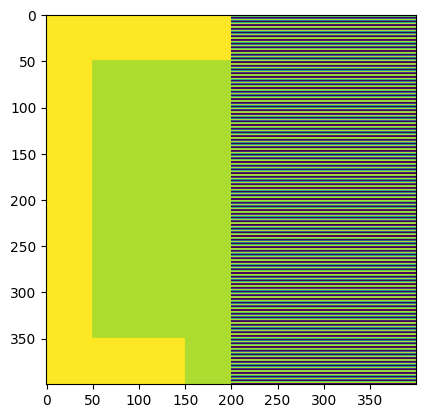

In [5]:
image = cv2.imread("samples/simple_lizard.png")
# image = cv2.resize(image, (300,400)) 
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)

n = 27  # size of the sub-image blocks (better if even)
offset = (n - 1) // 2

image_size = gray_image.shape
plt.imshow(gray_image)
plt.show()

## DRLSE

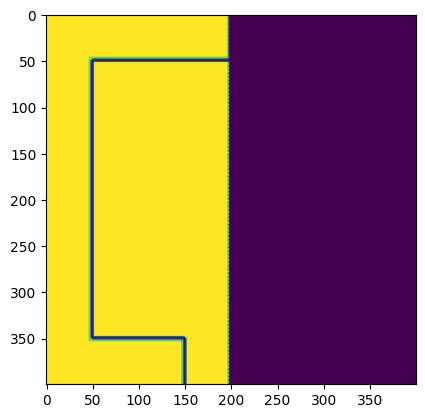

In [6]:
gray_smooth = gaussian_filter(gray_image, 0.8)
[Iy, Ix] = np.gradient(gray_smooth)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1 + f)  # edge indicator function.
plt.imshow(g)
plt.show()

In [7]:
iter_inner = 30
iter_outer = 30
timestep = 1
lmbda = 5
alfa = 2
epsilon = 1.5
sigma = 0.8

In [8]:
c0 = 2
initial_lsf = c0 * np.ones(g.shape)
# initial_lsf[5:-5, 5:-5] = -c0
# initial_lsf[50:350, 50:250] = -c0
initial_lsf[25:400, 25:400] = -c0
# initial_lsf[70:750, 100:400] = -c0 # lizard

phi = find_lsf(
    g=g, 
    initial_lsf=initial_lsf,
    timestep=timestep,
    iter_inner=iter_inner,
    iter_outer=iter_outer,
    lmda=lmbda,
    alfa=alfa,
    epsilon=epsilon)

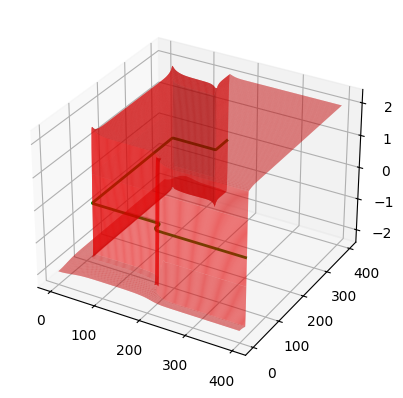

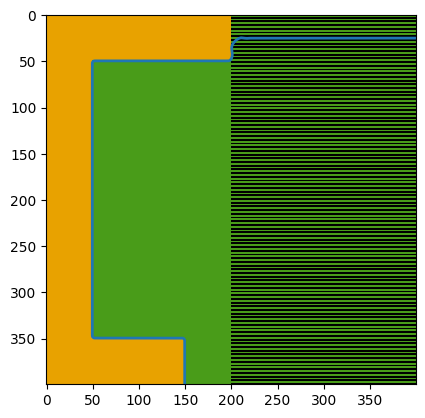

In [9]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi, 0)
ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

## Texture features

### Features

In [10]:
def normalize(image):
    """Normalizes the image intensity values to the range [0, 1]."""
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) / (image_max - image_min)
    return normalized_image

def log_normalize(image):
    """Logarithmically normalizes the image intensity values to the range [0, 1]."""
    image = np.real(np.log(image + 1))
    return normalize(image)

def energy(comat):
    """Calculates the energy feature from the co-occurrence matrix."""
    term = np.power(comat.flatten(), 2)

    return np.sum(term)

def contrast(comat, r, c):
    """Calculates the contrast feature from the co-occurrence matrix."""
    term1 = np.power(r - c, 2)
    term2 = comat.flatten()

    return np.sum(term1 * term2)


def cluster_shade(comat, r, c, Mx, My):
    """Calculates the cluster shade feature from the co-occurrence matrix."""
    term1 = np.power((r - Mx + c - My), 3)
    term2 = comat.flatten()

    return np.sum(term1 * term2)


def cluster_prominence(comat, r, c, Mx, My):
    """Calculates the cluster prominence feature from the co-occurrence matrix."""
    term1 = np.power((r - Mx + c - My), 4)
    term2 = comat.flatten()

    return np.sum(term1 * term2)

In [11]:
def wavelet_coefficient_features(block):
    block = block - np.mean(block, dtype=np.uint8) # idea from Mr Meert Wannes, maybe do something with negative values

    A1, (H1, V1, D1) = pywt.dwt2(block, 'haar')
    # A2, (H2, V2, D2) = pywt.dwt2(A1, 'haar')


    comatrix_level = 32
    distances = [1]
    setup = [
        {
            "image": (block/(256/comatrix_level)).astype(np.uint8),
            "angles": [0, np.pi/4, np.pi/2, 3*np.pi/4]
        },
        {
            "image": ((H1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [0]
        },
        {
            "image": ((V1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [np.pi/2]
        },
        {
            "image": ((D1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [np.pi/4, 3*np.pi/4]
        },
        # {
        #     "image": ((H2 + abs(H2.flatten().min()))/((H2 + abs(H2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [0]
        # },
        # {
        #     "image": ((V2 + abs(V2.flatten().min()))/((V2 + abs(V2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [np.pi/2]
        # },
        # {
        #     "image": ((D2 + abs(D2.flatten().min()))/((D2 + abs(D2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [np.pi/4, 3*np.pi/4]
        # }
    ]

    comatrices = np.array([], dtype=np.int64).reshape(comatrix_level,comatrix_level,0)
    for x in setup:
        subimage = x["image"]
        c = graycomatrix(subimage, distances, x["angles"], levels=comatrix_level, normed=True)
        c = c.reshape((c.shape[0], c.shape[1], c.shape[2]*c.shape[3]))
        comatrices = np.concatenate((comatrices, c), axis=2)

    r, c = np.meshgrid(np.arange(comatrices.shape[0]), np.arange(comatrices.shape[1]))
    r = r.flatten() + 1
    c = c.flatten() + 1

    features = np.zeros((8,7))

    for ci in range(comatrices.shape[2]):
        Mx = np.sum(r * comatrices[:,:,ci].flatten())
        My = np.sum(c * comatrices[:,:,ci].flatten())

        features[ci, 0] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'energy')[0,0]
        features[ci, 1] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'contrast')[0,0]
        features[ci, 2] = cluster_shade(comatrices[:,:,ci], r, c, Mx, My) + cluster_prominence(comatrices[:,:,ci], r, c, Mx, My)
        features[ci, 3] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'dissimilarity')[0,0]
        features[ci, 4] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'homogeneity')[0,0]
        features[ci, 5] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'ASM')[0,0]
        features[ci, 6] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'correlation')[0,0]
    
    return features

In [12]:
WCFs = np.zeros((image_size[0], image_size[1], 8, 7))

class fnc_class:
    def __init__(self, _array):
        # store the shape:
        self.shape = _array.shape
        self._array = _array
        # initialize the coordinates:
        self.coordinates = [0] * len(self.shape[:2])

    def filter(self, buffer):
        block = buffer.reshape(n,n)

        self._array[self.coordinates[0], self.coordinates[1]] = wavelet_coefficient_features(block)

        # calculate the next coordinates:
        axes = range(len(self.shape[:2]))
        for jj in reversed(axes):
            if self.coordinates[jj] < self.shape[jj] - 1:
                self.coordinates[jj] += 1
                break
            else:
                self.coordinates[jj] = 0

        return 0

fnc = fnc_class(WCFs)
generic_filter(gray_image, fnc.filter, n)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
# filename = 'WCFs_lizard.npy'
# filename = 'WCFs_simple_lizard.npy'
# filename = 'WCFs_different_props.npy'


# with open(filename, 'wb') as f:
#     np.save(f, WCFs)

# with open(filename, 'rb') as f:
#     WCFs = np.load(f)

In [13]:
def plot_features(features):
    for i in range(features.shape[3]):
        for j in range(features.shape[2]):
            plt.subplot(features.shape[3],features.shape[2],(i*features.shape[2])+j+1)
            plt.imshow(features[:,:,j,i])
    plt.show()

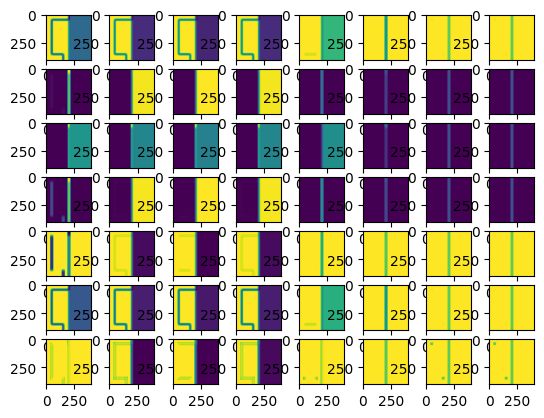

In [14]:
plot_features(WCFs)

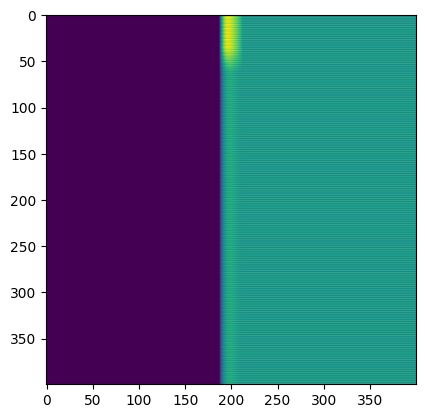

In [15]:
plt.imshow(np.mean(np.mean(WCFs, 3), 2))
plt.show()

In [16]:
normalizedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    normalizedWCFs[:,:, i, 0] = normalize(WCFs[:,:,i, 0])
    normalizedWCFs[:,:, i, 1] = normalize(WCFs[:,:,i, 1])
    normalizedWCFs[:,:, i, 2] = log_normalize(WCFs[:,:,i, 2])
    normalizedWCFs[:,:, i, 3] = normalize(WCFs[:,:,i, 3])
    normalizedWCFs[:,:, i, 4] = normalize(WCFs[:,:,i, 4])
    normalizedWCFs[:,:, i, 5] = normalize(WCFs[:,:,i, 5])
    normalizedWCFs[:,:, i, 6] = normalize(WCFs[:,:,i, 6])

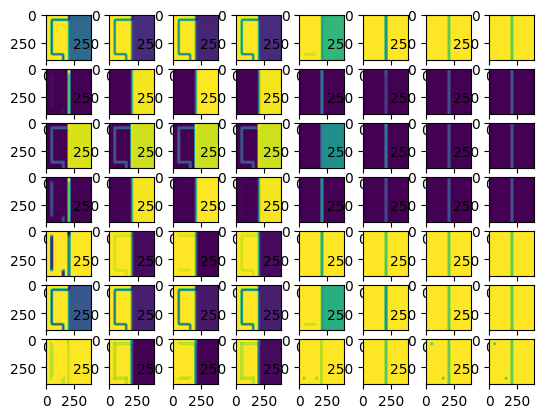

In [17]:
plot_features(normalizedWCFs)
plt.show()

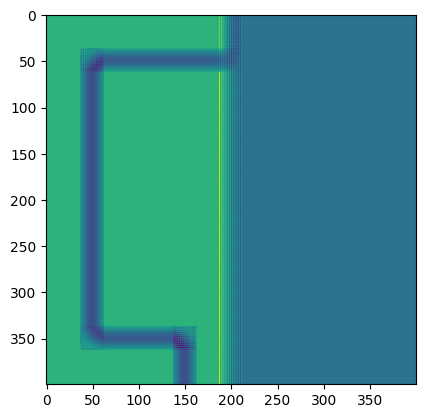

In [18]:
plt.imshow(np.mean(np.mean(normalizedWCFs, 3), 2))
plt.show()

In [19]:
normalizedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        blurred = gaussian_filter(WCFs[:,:,i, j], sigma)
        erosion = grey_erosion(blurred, 3)
        normalizedWCFs[:,:, i, j] = grey_dilation(erosion, 3)
        
    normalizedWCFs[:,:, i, 0] = normalize(normalizedWCFs[:,:,i, 0])
    normalizedWCFs[:,:, i, 1] = normalize(normalizedWCFs[:,:,i, 1])
    normalizedWCFs[:,:, i, 2] = log_normalize(normalizedWCFs[:,:,i, 2])
    normalizedWCFs[:,:, i, 3] = normalize(normalizedWCFs[:,:,i, 3])
    normalizedWCFs[:,:, i, 4] = normalize(normalizedWCFs[:,:,i, 4])
    normalizedWCFs[:,:, i, 5] = normalize(normalizedWCFs[:,:,i, 5])
    normalizedWCFs[:,:, i, 6] = normalize(normalizedWCFs[:,:,i, 6])

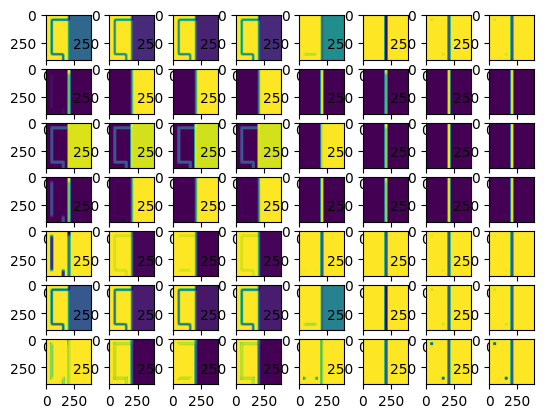

In [20]:
plot_features(normalizedWCFs)

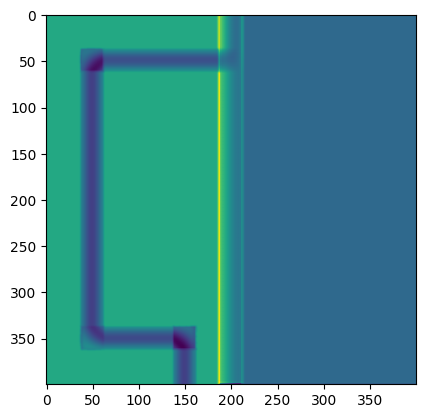

In [21]:
plt.imshow(np.mean(np.mean(normalizedWCFs, 3), 2))
plt.show()

In [30]:
invertedWCFs = normalizedWCFs.copy()
X = np.zeros((0, image_size[0], image_size[1]))
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        inverted = (invertedWCFs[:,:,i, j] - 1) * -1


        if metrics.mean_squared_error(np.mean(X, axis=0), invertedWCFs[:,:,i, j]) > metrics.mean_squared_error(np.mean(X, axis=0), inverted):
            invertedWCFs[:,:, i, j] = inverted

        X = np.concatenate((X, [invertedWCFs[:,:,i,j]]), axis=0)
    
    # for j in range(WCFs.shape[3]):
    #     x = np.mean(normalizedWCFs[:,:,i,j])
    #     y = np.mean(normalizedWCFs[:,:,0,0][phi<0])
    #     if x > y:
    #         invertedWCFs[:,:,i,j] = (normalizedWCFs[:,:,i,j] - 1) * -1
    #     else:
    #         invertedWCFs[:,:,i,j] = normalizedWCFs[:,:,i,j]

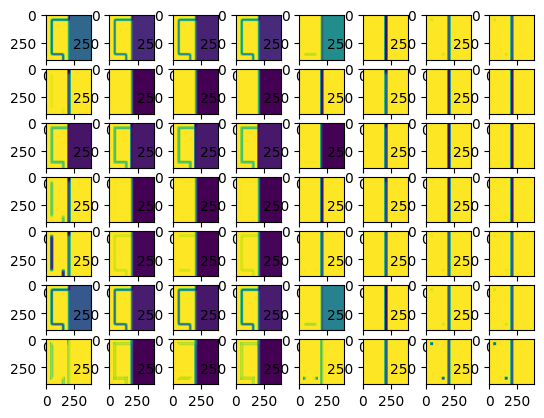

In [31]:
plot_features(invertedWCFs)

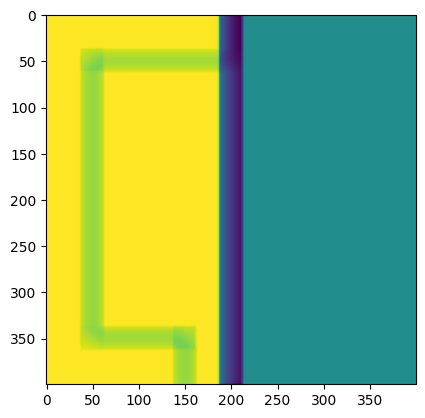

In [32]:
plt.imshow(np.mean(np.mean(invertedWCFs, 3), 2))
plt.show()

In [33]:
filteredWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        filteredWCFs[:,:, i, j] = minimum_filter(invertedWCFs[:,:,i,j], n)

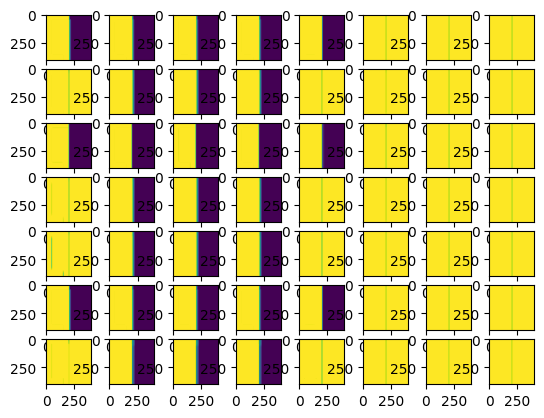

In [34]:
plot_features(filteredWCFs)

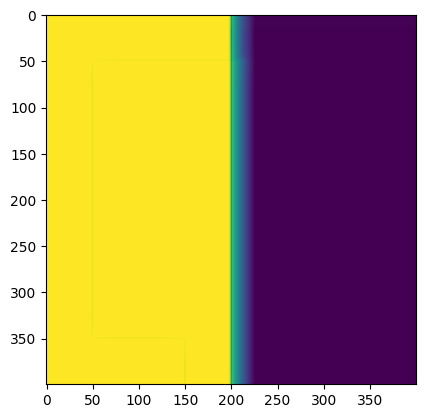

In [35]:
plt.imshow(np.mean(np.mean(filteredWCFs, 3), 2))
plt.show()

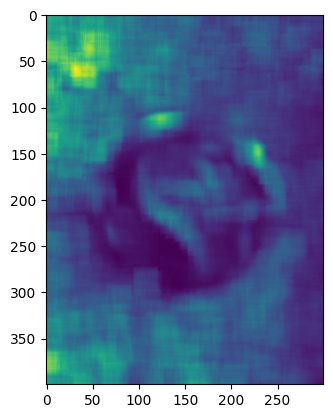

In [213]:
X = np.zeros((image_size[0], image_size[1], 8, 7))
for i in range(WCFs.shape[2]):
    X[:,:, i, 0] =WCFs[:,:,i, 0]
    X[:,:, i, 1] =WCFs[:,:,i, 1]
    X[:,:, i, 2] =WCFs[:,:,i, 2] + WCFs[:,:,i, 3]
    X[:,:, i, 3] =WCFs[:,:,i, 4]
    X[:,:, i, 4] =WCFs[:,:,i, 5]
    X[:,:, i, 5] =WCFs[:,:,i, 6]
plt.imshow(np.mean(np.mean(X, 3), 2))

### Segementation band

In [36]:
smoothedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        smoothedWCFs[:,:, i, j] = median_filter(filteredWCFs[:,:,i,j], n)

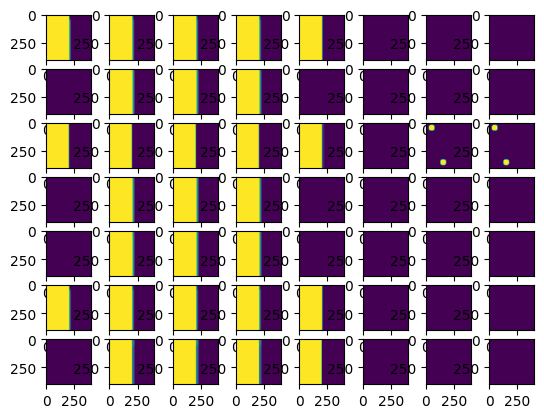

In [37]:
plot_features(smoothedWCFs)

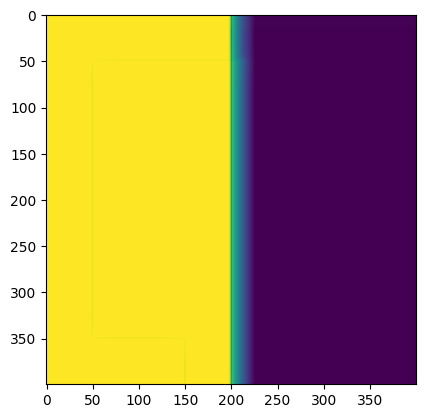

In [72]:
combinedWCFs = np.mean(np.mean(filteredWCFs, 3), 2)

plt.imshow(combinedWCFs)
plt.show()

d:\Projects\Masterproef\unsupervised-image-segmentation-texture-based\.venv\Lib\site-packages\scipy\stats\_stats_py.py:197: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)


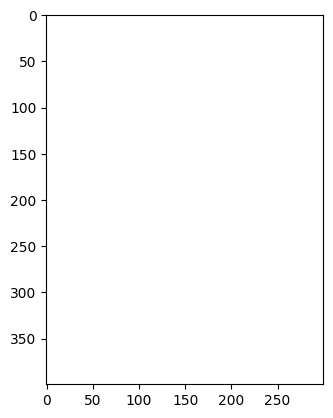

In [96]:
combinedWCFs = gmean(gmean(smoothedWCFs, 3), 2)

plt.imshow(combinedWCFs)
plt.show()

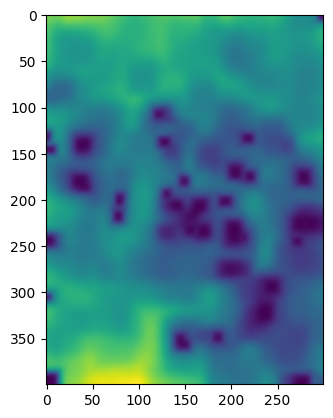

In [39]:
combinedWCFs = hmean(hmean(smoothedWCFs + 0.000000001, 3), 2)

plt.imshow(combinedWCFs)
plt.show()

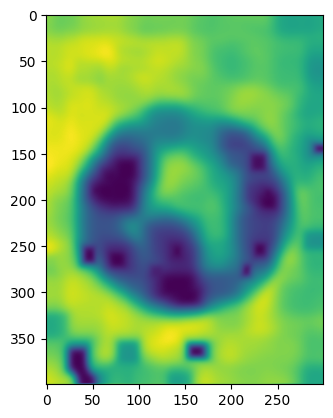

In [138]:
smoothedWCFs = gaussian_filter(combinedWCFs, sigma, mode='wrap')
plt.imshow(smoothedWCFs)
plt.show()

In [334]:
X = (((phi<0) - 1) * -1).astype(np.float64)
X[X == 1] = np.max(smoothedWCFs)

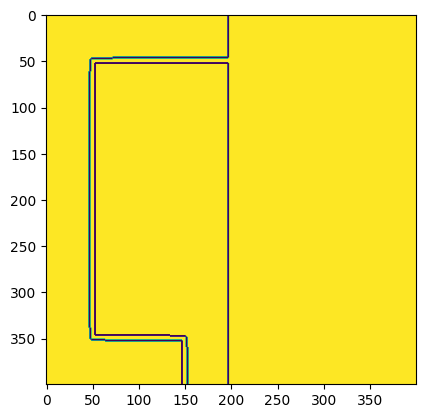

In [71]:
[Iy, Ix] = np.gradient(combinedWCFs * 255)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1 + f)

# gray_smooth = gaussian_filter(gray_image, 0.8)
# [Iy, Ix] = np.gradient(gray_smooth)
# f = np.square(Ix) + np.square(Iy)
# g2 = 1 / (1 + f)  # edge indicator function.
# plt.imshow(g2)
# plt.show()

plt.imshow(g)
plt.show()

In [221]:
iter_inner = 30
iter_outer = 10
timestep = 1
lmbda = 5
alfa = 2
epsilon = 1.5
sigma = 0.8

In [222]:
phi_modified = find_lsf(
    g=g, 
    initial_lsf=phi,
    timestep=timestep,
    iter_inner=iter_inner,
    iter_outer=iter_outer,
    lmda=lmbda,
    alfa=alfa,
    epsilon=epsilon)

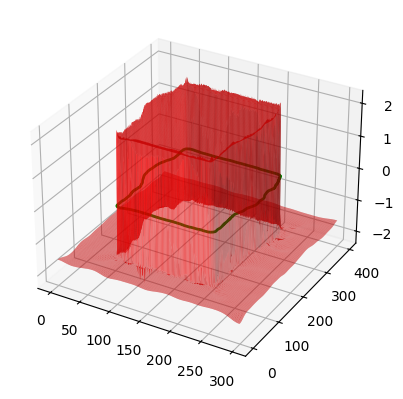

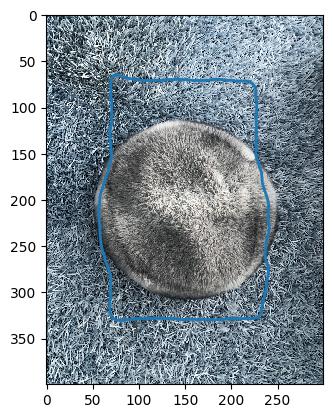

In [223]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi_modified.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi_modified, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi_modified, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi_modified, 0)
ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

In [ ]:
segmentation_bands = np.zeros(normalizedWCFs.shape)

for i in range(normalizedWCFs.shape[2]):
    for j in range(normalizedWCFs.shape[3]):
        # segmentation_bands[offset:-offset,offset:-offset, i, j] = gaussian_filter(normalizedWCFs[offset:-offset,offset:-offset, i, j], sigma)
        # segmentation_bands[offset:-offset,offset:-offset, i, j] = minimum_filter(segmentation_bands[offset:-offset,offset:-offset, i, j], n)
        segmentation_bands[:,:, i, j] = np.sum(np.abs(np.gradient(normalizedWCFs[:,:, i, j])), axis=0)

plot_features(segmentation_bands)

plt.imshow(np.mean(np.mean(segmentation_bands, 3), 2))
plt.show()

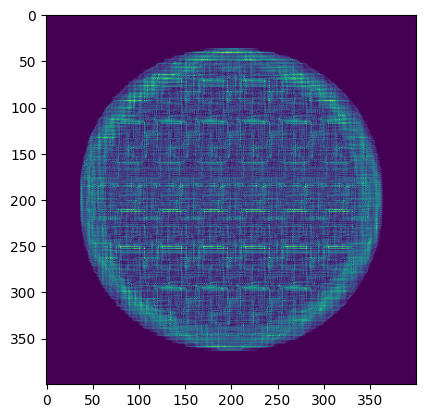

In [21]:
segmentation_band = np.sum(np.abs(np.gradient(combinedWCFs)), axis=0)

# interest_region = (phi<0).astype(np.uint8)
# borders = np.sum(np.abs(np.gradient(interest_region)), axis=0) > 0

segmentation_band = segmentation_band # - (segmentation_band * borders)

plt.imshow(segmentation_band)
plt.show()

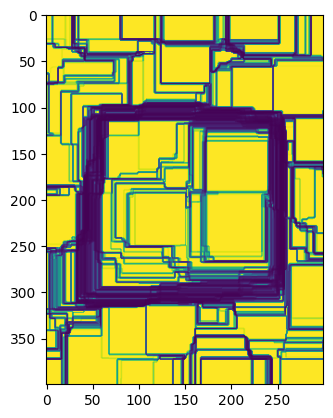

In [108]:
plt.imshow(segmentation_bands[:,:, 5, 6])

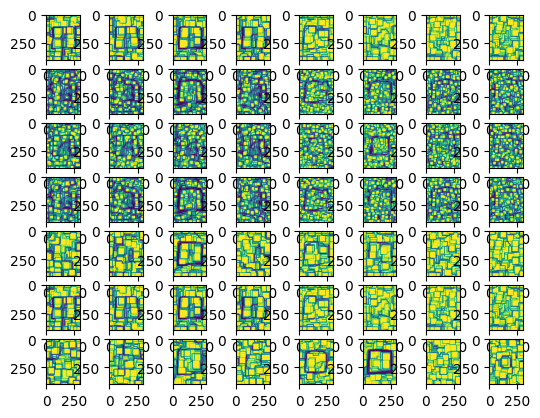

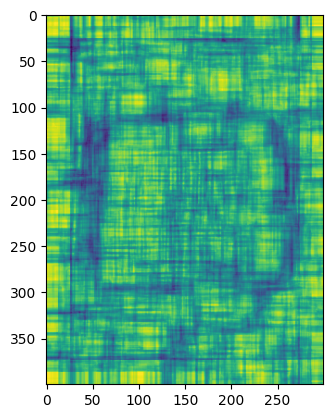

In [107]:
segmentation_bands = np.zeros(normalizedWCFs.shape)

for i in range(normalizedWCFs.shape[2]):
    for j in range(normalizedWCFs.shape[3]):
        # segmentation_bands[offset:-offset,offset:-offset, i, j] = gaussian_filter(normalizedWCFs[offset:-offset,offset:-offset, i, j], sigma)
        # segmentation_bands[offset:-offset,offset:-offset, i, j] = minimum_filter(segmentation_bands[offset:-offset,offset:-offset, i, j], n)
        [Iy, Ix] = np.gradient(filteredWCFs[:,:, i, j] * 255)
        f = np.square(Ix) + np.square(Iy)
        g = 1 / (1 + f)
        
        segmentation_bands[:,:, i, j] = g

plot_features(segmentation_bands)

plt.imshow(np.mean(np.mean(segmentation_bands, 3), 2))
plt.show()

### Thresholding

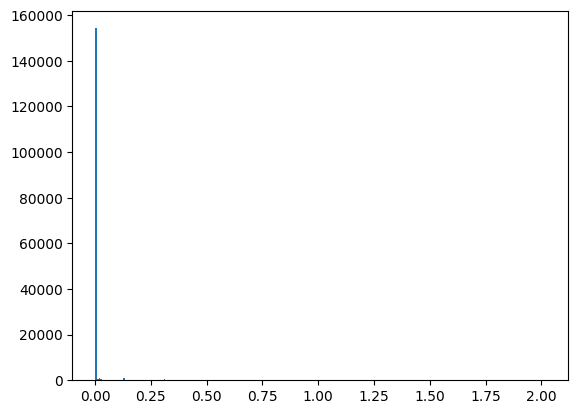

In [42]:
plt.hist(segmentation_band.ravel(), bins=256)
plt.show()

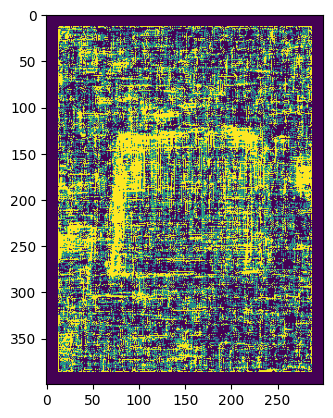

In [160]:
thresh = threshold_mean(segmentation_band)
binary = segmentation_band > thresh
plt.imshow(binary)
plt.show()

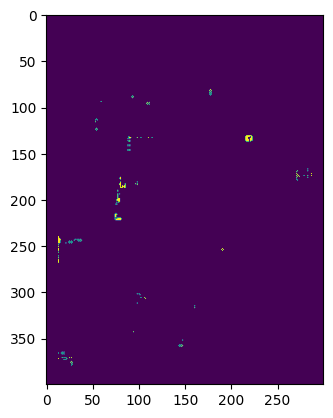

In [161]:
thresh = threshold_otsu(segmentation_band)
binary = segmentation_band > thresh
plt.imshow(binary)
plt.show()

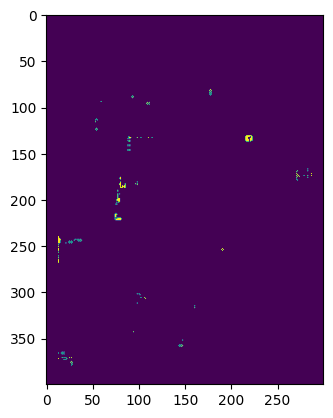

In [162]:
local_thresh = threshold_local(segmentation_band, 35)
binary = segmentation_band > thresh
plt.imshow(binary)
plt.show()

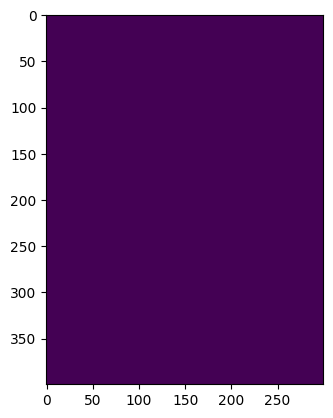

In [163]:
binary = gaussian_filter(segmentation_band, 0.8)>0.4
binary = binary.astype(np.uint8)
plt.imshow(binary)

### Skeletonizing

1.0


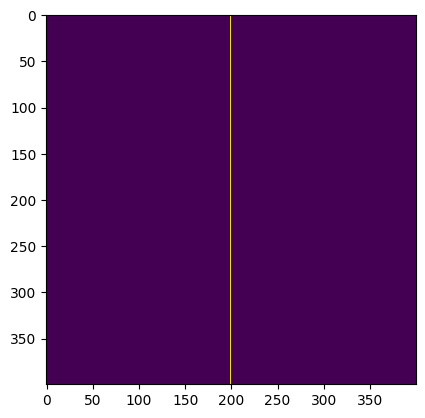

In [235]:
skeleton = np.zeros(image_size)

binary_filled_borders = np.ones((image_size[0]+offset*4, image_size[1]+offset*4))
binary_filled_borders[offset*3:-offset*3, offset*3:-offset*3] = binary[offset:-offset, offset:-offset]

print(np.max(binary_filled_borders))

skeleton = skeletonize(binary_filled_borders, method='lee')[offset*2:-offset*2, offset*2:-offset*2]
plt.imshow(skeleton)

In [236]:
np.min(phi)

-2.3094993827283594

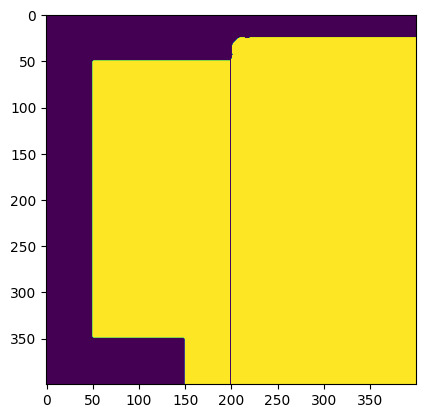

In [237]:
plt.imshow(phi + skeleton*4 < 0)

[[400.5 400. ]
 [400.5 399. ]
 [400.5 398. ]
 ...
 [399.  400.5]
 [400.  400.5]
 [400.5 400. ]]
[[400.5 199. ]
 [400.5 198. ]
 [400.5 197. ]
 ...
 [399.  199.5]
 [400.  199.5]
 [400.5 199. ]]


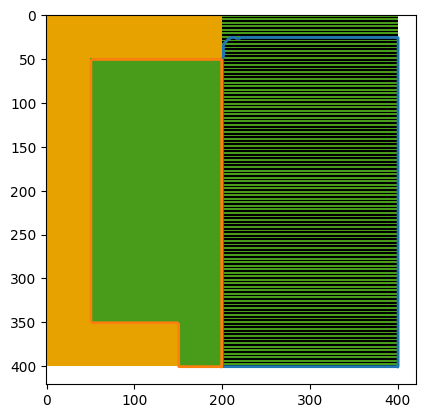

In [238]:
X = np.zeros((image_size[0]+2, image_size[1]+2))
X[1:-1, 1:-1] = (phi + skeleton*4) < 0

contours = measure.find_contours(X, fully_connected='low')
plt.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
    print(contour)

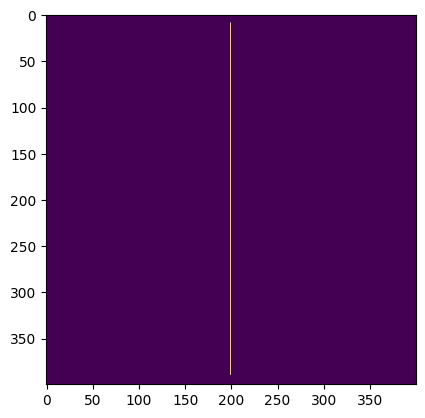

In [92]:
skeleton = skeletonize(binary, method='lee')
plt.imshow(skeleton)

### Segmentation

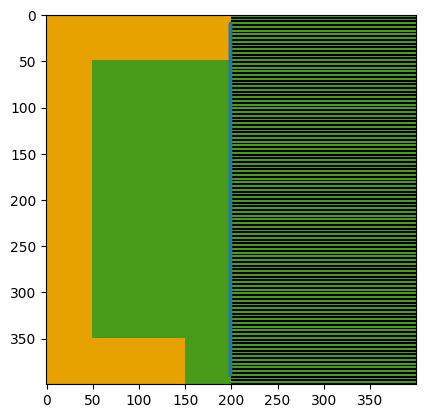

In [27]:
contours = measure.find_contours(skeleton, fully_connected='high')
plt.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

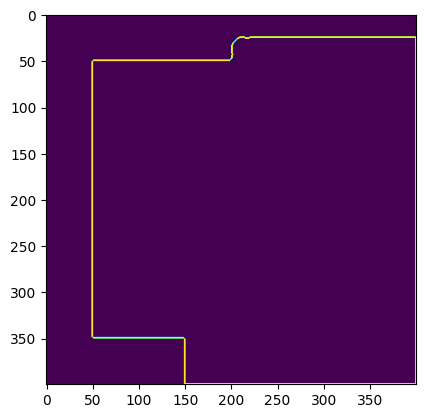

In [124]:
# how to do this different?

interest_region = (phi<0).astype(np.uint8)

X = np.zeros((image_size[0]+2, image_size[1]+2))
X[1:-1, 1:-1] = interest_region

gradient = np.sum(np.abs(np.gradient(X)), axis=0)
borders = gradient[1:-1, 1:-1] > 0
plt.imshow(borders)

In [125]:
binary_filled = np.ones((image_size[0] + n-1, image_size[1] + n-1))
binary_filled[n-1:-n+1, n-1:-n+1] = binary_fill_holes(binary).astype(np.uint8)
plt.imshow(binary_filled)

ValueError: could not broadcast input array from shape (400,400) into shape (0,0)

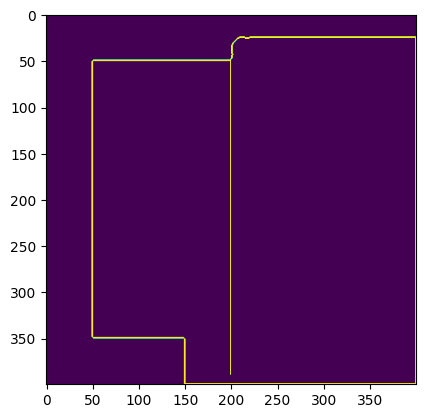

In [126]:
combined_borders = borders | (skeleton * interest_region > 0)
plt.imshow(combined_borders)

2


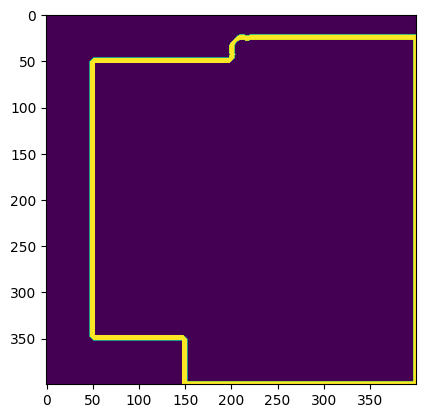

In [127]:
result = np.zeros(image_size)

contours, hierarchy = cv2.findContours(borders.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# approximate contour
# for contour in contours:
#     perimeter = cv2.arcLength(contour, True)
#     approximatedShape = cv2.approxPolyDP(contour, 0.02 * perimeter, True)

print(len(contours))
cv2.drawContours(result, contours, -1, 255, 3)
plt.imshow(result)

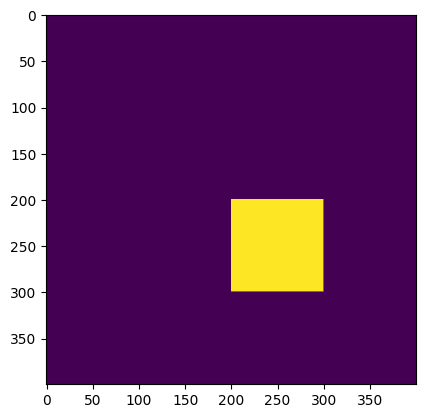

In [128]:
img = np.zeros(image_size)
img[200:300, 200:300] = 100
plt.imshow(img.astype(np.uint8))

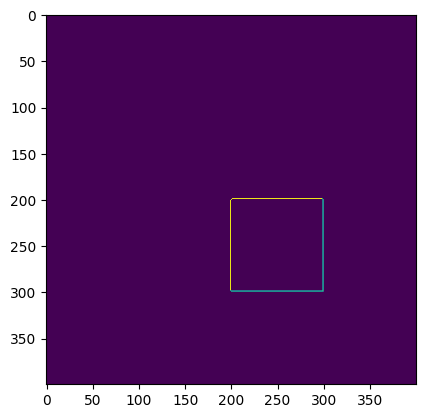

In [ ]:
edge_image = cv2.Canny(img.astype(np.uint8),100,200)
plt.imshow(edge_image)

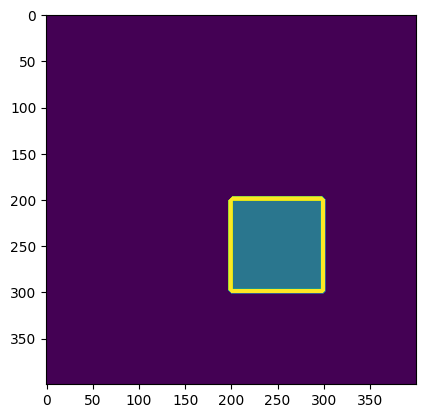

In [ ]:
contours, hierarchy = cv2.findContours(edge_image.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, 255, 3)
plt.imshow(img)

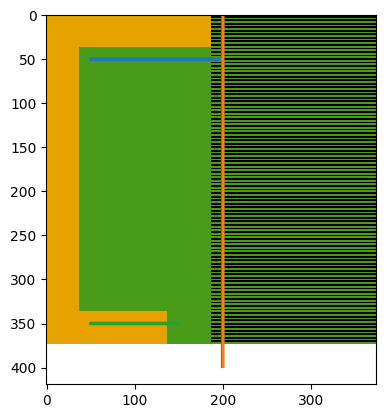

In [ ]:
contours = measure.find_contours(skeleton, fully_connected='high')
plt.imshow(original_image[offset:-offset, offset:-offset], interpolation='nearest', cmap=plt.get_cmap('gray'))
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2)

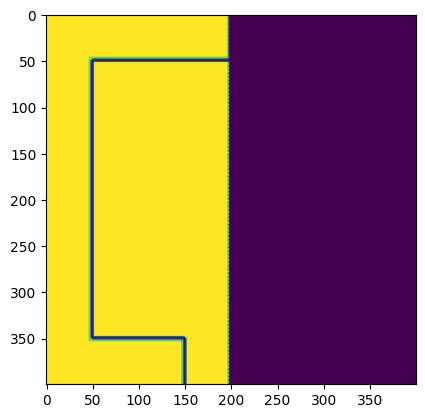

In [ ]:
gray_smooth = gaussian_filter(gray_image, sigma)
[Iy, Ix] = np.gradient(gray_smooth)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1 + f)
plt.imshow(g)